# Assignment 1: Chroma key compositing

- Nome: Luis Raul Sanchez Vazquez
- Email: raulsanchez@dcc.ufmg.br
- Matricula: 2015705672

![title](example_img.png)

## Introduction

Chroma key compositing is a post-production technique for compositing two images or video streams together based on color hues, allowing to remove a background from the subject of a photo or video.

Such processes is made possible by making transparent a foreground of an image, where its foreground is composed of green and blue backgrounds that facilitates the process of isolate the interesting parts of an image from their irrelevant background, preserving only the pixels of interests.

# Overview

In this work, we will mainl rely on skimage python toolkit to perform imaging operations in order to:

- Remove a green background from an image while isolating an object.
- Blend multiple images in a single image permiting basic rotation, translation, scale operations.
- Apply basic filters on images.
- Save image on disk

In [1]:
import warnings; warnings.filterwarnings('ignore');

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.misc import imread

import skimage
from skimage import img_as_ubyte
from skimage.transform import rescale
from skimage.transform import rotate
from skimage import io
from skimage import filters
from skimage import exposure
from skimage.morphology import disk
from skimage.filters import rank

#File where to save the final image of this document
output_filename = 'outfile.png'

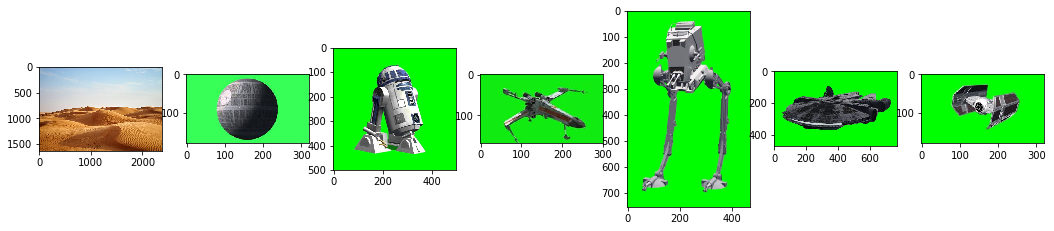

In [2]:
"""
Load images
"""
bg = imread('bg.png', mode='RGBA')
deadmoon = imread('deadmoon.jpg', mode='RGBA')
r2d2 = imread('R2D2.png', mode='RGBA')
stormtrooper = imread('stormtrooper.png', mode='RGBA')
atst = imread('atst.png', mode='RGBA')
falcon = imread('falcon.png', mode='RGBA')
fighter = imread('fighter.jpg', mode='RGBA')

"""
Display
"""
fig, ax = plt.subplots(1, 7)

ax[0].imshow(bg)
ax[1].imshow(deadmoon)
ax[2].imshow(r2d2)
ax[3].imshow(stormtrooper)
ax[4].imshow(atst)
ax[5].imshow(falcon)
ax[6].imshow(fighter)

fig.set_size_inches(18, 5)

# Chroma-key with Green foreground


## Remove green background

In mathematics, a **ratio** is a relationship between two numbers indicating how many times the first number contains the second. 

Following this notion of ration, the chroma-key strategy implemented in this document is based on the **ratio of the green, red, and blue channels compared to the max-brightness level found on the pixel**.

Therefore, if the **green-ratio** is found systematically higher than the **red-ratio** and the **blue-ratio** it arguably implies the prevalence a green-ish color in the pixel. Based on such nuance of green-ish pixel a threshold constraint is imposed in order to determine whether or not to preserve the pixel by setting a close to zero alpha value, which eventually will lead to completelly ignore such pixel.

In [3]:
def remove_green(img):
    """
    Docstring:
        Remove green-ish background from image given a threshold.

    Parameters
    ----------
    img : numpy.array containing 4 channel image (RGBa).
    """
    
    norm_factor = 255

    """
    Obtain the ratio of the green/red/blue
    channels based on the max-bright of 
    the pixel.
    """
    
    red_ratio = img[:, :, 0] / norm_factor
    green_ratio = img[:, :, 1] / norm_factor
    blue_ratio = img[:, :, 2] / norm_factor

    """
    Darker pixels would be around 0.
    In order to ommit removing dark pixels we
    sum .3 to make small negative numbers to be
    above 0.
    """
    
    red_vs_green = (red_ratio - green_ratio) + .3
    blue_vs_green = (blue_ratio - green_ratio) + .3

    """
    Now pixels below 0. value would have a
    high probability to be background green
    pixels.
    """
    red_vs_green[red_vs_green < 0] = 0
    blue_vs_green[blue_vs_green < 0] = 0

    """
    Combine the red(blue) vs green ratios to
    set an alpha layer with valid alpha-values.
    """
    alpha = (red_vs_green + blue_vs_green) * 255
    alpha[alpha > 50] = 255

    """
    Set the alpha layer
    """
    img[:, :, 3] = alpha

    return img

### Example

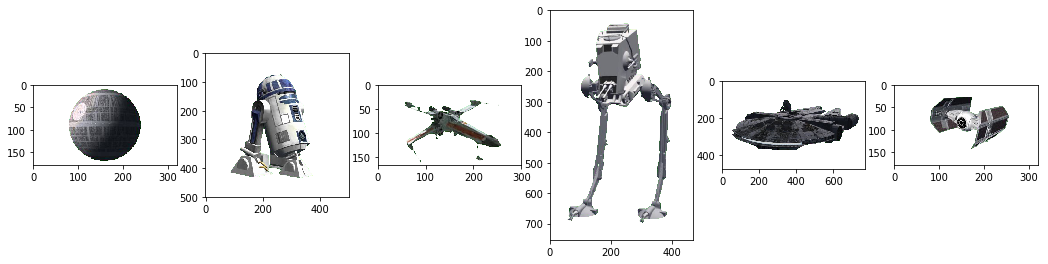

In [4]:
"""
Remove green from images
"""
remove_green(deadmoon)
remove_green(r2d2)
remove_green(stormtrooper)
remove_green(atst)
remove_green(falcon)
remove_green(fighter)

"""
Display
"""
fig, ax = plt.subplots(1, 6)

ax[0].imshow(deadmoon)
ax[1].imshow(r2d2)
ax[2].imshow(stormtrooper)
ax[3].imshow(atst)
ax[4].imshow(falcon)
ax[5].imshow(fighter)

fig.set_size_inches(18, 5)

## Blend images

In this document, the coordinate axes of an image start at the top-left corner of an image.

In this document, during the blending process it would be permited to rotate, scale, and position the image to be blended on top of the background image.

In [5]:
def blend(bg, img, coord=(0, 0), scale=None, angle=None):
    """
    Docstring:
        Blends two images, one as background and one on top, the image
        on top must be an image with alpha layer in order to perform
        organic blendings.

    Parameters
    ----------
    bg : Background image
    img : numpy.array, 4 channel image (RBGa)
    coord : coordinates of the blending position of img in bg.
    scale : Scale operation to perform on img [-Inf, Inf]
    angle : Rotation angle in degrees in img.
    
    Return
    ----------
    np.array : blended composition
    """
    
    #Perform scaling
    if not(scale is None):
        img = rescale(
            img, 
            scale)
    
    #Perform rotation
    if not(angle is None):
        img = rotate(
            img, 
            angle,
            resize=True, 
            mode='edge')
    
    img = img_as_ubyte(img)
    
    (x_size, y_size, _) = img.shape

    (y_ini, x_ini) = coord
    x_end = x_ini + x_size
    y_end = y_ini + y_size

    bg_crop = bg[
        x_ini:x_end,
        y_ini:y_end, 
        :]

    pixel_preserve = (img[:, :, -1] > 10)
    bg_crop[pixel_preserve] = img[pixel_preserve]

    bg[x_ini:x_end, y_ini:y_end, :] = bg_crop

    return bg

### Example

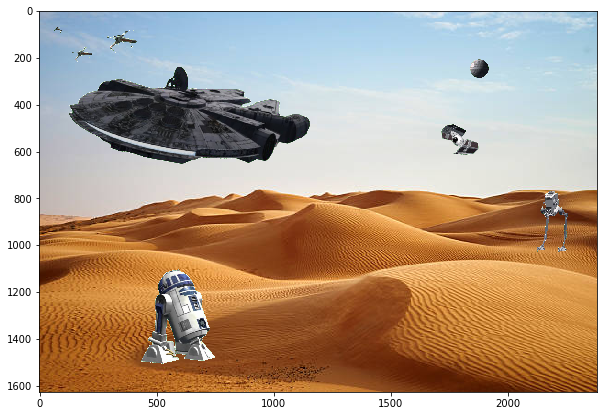

In [6]:
img = bg.copy()

img = blend(
    img, falcon,
    coord=(0, 0),
    scale=1.5,
    angle=-10)

img = blend(
    img, deadmoon,
    coord=(1800, 200),
    scale=.5)

img = blend(
    img, r2d2,
    coord=(300, 1000),
    angle=5,
    scale=1.1)

img = blend(
    img, atst,
    coord=(2100, 750),
    scale=.4)

img = blend(
    img, stormtrooper,
    coord=(50, 60),
    scale=.2)

img = blend(
    img, stormtrooper,
    coord=(115, 130),
    angle=20,
    scale=.4)

img = blend(
    img, stormtrooper,
    coord=(250, 50),
    angle=15,
    scale=.6)

img = blend(
    img,  fighter,
    coord=(1600, 400),
    angle=-30,
    scale=1.)

fig, ax = plt.subplots(1, 1)
ax.imshow(img)
fig.set_size_inches(10, 10)

## Channel adjustment and Contrast

### Choosing adjustment curves

In image editing, a curve is a remapping of image tonality, specified as a function from input level to output level, used as a way to emphasize colours or other elements in a picture.

Curves can usually be applied to all channels together in an image, or to each channel individually.

Applying a curve to individual channels can be used to stress a colour.

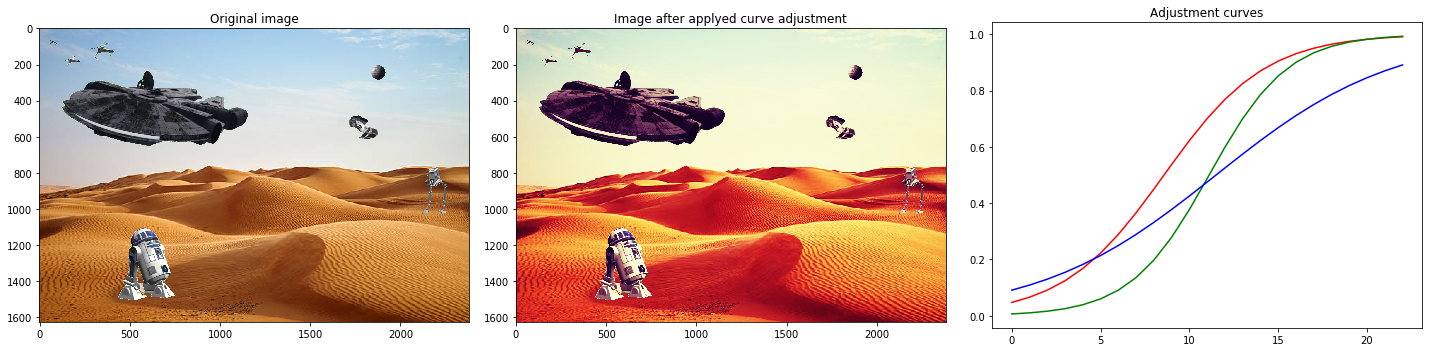

In [7]:
def sigmoid(x):
    """
    params
    ----------
    x : np.array with x values of a sigmoid
    Sigmoid function.
    
    return
    ----------
    np.array : y-sigmoid values of x
    """
    return 1 / (1 + np.exp(-x))

def channel_adjust(img, curve, channel):
    """
    Adjust channel.
    
    Thanks to:
        http://www.practicepython.org/blog/2016/12/20/instagram-filters-python.html
    params
    ------
    single_img_channel : 2-D array corresponding to a single channel image
    curve : Curve to which correct the pixels brightness
    
    returns
    ------
    np.array : The adjusted channel
    """
    regular_inntervals = np.linspace(0, 1, len(curve))
    
    adjustment_flat = np.interp(
        img[:, :, channel].ravel(), 
        regular_inntervals,
        curve)
    shape = img[:, :, channel].shape
    
    adjustment = adjustment_flat.reshape(shape)
    img[:, :, channel] = adjustment
    
    return

#Make adjust curves
red_adjust_curve = sigmoid(np.arange(-3, 5, .35))
green_adjust_curve = sigmoid(np.arange(-5, 5, .45))
blue_adjust_curve = sigmoid(np.arange(-2.3, 2.3, .2))

fig, ax = plt.subplots(1, 3)

img_effect = skimage.img_as_float(
    img.copy())

channel_adjust(
    img_effect, 
    red_adjust_curve, 
    channel=0)

channel_adjust(
    img_effect, 
    green_adjust_curve, 
    channel=1)

channel_adjust(
    img_effect, 
    blue_adjust_curve, 
    channel=2)

ax[0].imshow(img);
ax[0].set_title('Original image')
ax[1].imshow(img_effect);
ax[1].set_title('Image after applyed curve adjustment')

pd.Series(red_adjust_curve).plot(
    c='r', ax=ax[2], title='Adjustment curves')
pd.Series(green_adjust_curve).plot(
    c='g', ax=ax[2])
pd.Series(blue_adjust_curve).plot(
    c='b', ax=ax[2])

fig.set_size_inches(14, 7)

fig.set_size_inches(20, 5)
fig.set_tight_layout('tight')

# Blur right side of the image

## Blurring

In order to blur the left side of the image, we will first create the desired blur image. Then, we will gradually decrease the alpha values gradually from right-to-left

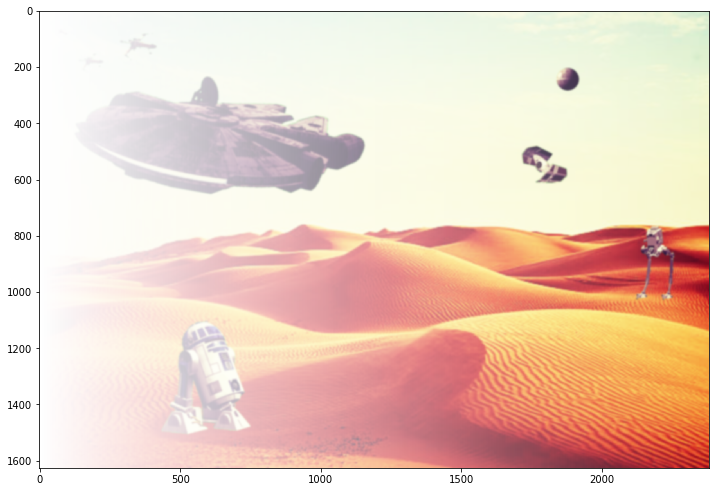

In [8]:
blurred = filters.gaussian(
    img_effect.copy(),
    sigma=3,
    multichannel=True)

shape_0 = blurred.shape[0]
shape_1 = blurred.shape[1]
blur_gradient = (1 - np.arange(0, 1, 1 / shape_1))

blur_gradient = blur_gradient.reshape(
    1, -1
).repeat(
    shape_0, axis=0
).reshape(shape_0, shape_1)

blurred[:, :, 3] = 1 - blur_gradient

fig, ax = plt.subplots(1, 1)
plt.imshow(blurred)
fig.set_size_inches(12, 12)

## Alpha compositing

In computer graphics, alpha compositing is the process of combining an image with a background to create the appearance of partial or full transparency. It is often useful to render image elements in separate passes, and then combine the resulting multiple 2D images into a single, final image called the composite.

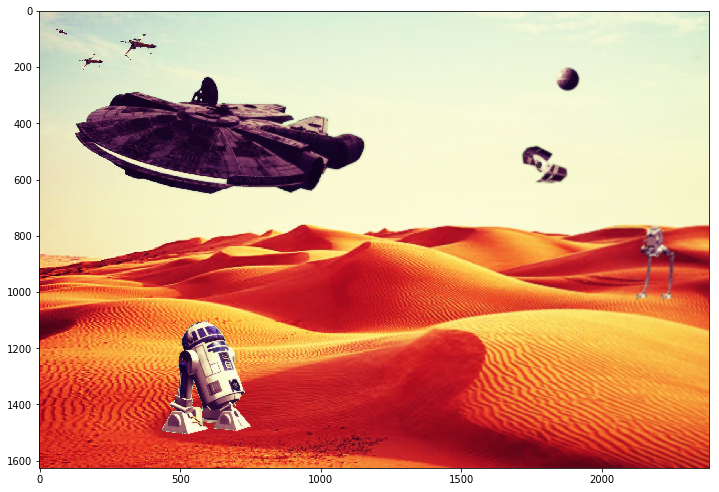

In [9]:
def merge_alpha(img, bg):
    """
    
    Thanks to:
        https://stackoverflow.com/questions/25182421/overlay-two-numpy-arrays-treating-fourth-plane-as-alpha-level
    """
    src_rgb = img[..., :3]
    src_a = img[..., 3]

    dst_rgb = bg[..., :3]
    dst_a = bg[..., 3]

    out_a = src_a + dst_a * (1.0 - src_a)
    out_rgb = (
        src_rgb*src_a[..., None] + dst_rgb*dst_a[..., None]*(1.0 - src_a[..., None])) / out_a[..., None]

    out = np.zeros_like(bg)
    out[..., :3] = out_rgb
    out[..., 3] = out_a
    
    return out

final = merge_alpha(blurred, img_effect)

fig, ax = plt.subplots(1, 1)

plt.imshow(final)

fig.set_size_inches(12, 12)

In [10]:
io.imsave(
    output_filename, 
    skimage.img_as_uint(final))